# Jena Climate Dataset

### Contexto:
- O dataset é uma base temporal de medições climáticas, que envolvem pressão do ar, temperatura, umidade e informações do vento.
- As datas estão dividida em janelas de 10min, com alguns saltos temporais pequenos (até 3 dias) e varia de 01/01/2009 a 01/01/2017.

### Objetivo: 
- Prever a temperatura nas próximas 24 horas, baseada nas observações anteriores.

### Métrica de Objetivo: Mean Absolute Error (MAE)

In [33]:
import sys
sys.path.append('..')
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style()
from datetime import time, date
from src.utils import plot_corr_heatmap, plot_histograms_features
sns.set_style("dark")
sns.set_palette("dark")

In [34]:
df = pd.read_csv("../data/jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [35]:
df.columns = [
    "date",
    "internal_pressure",
    "temperature_celsius",
    "temperature_kelvin",
    "dew_point",
    "relative_humidity",
    "saturation_vapor_pressure",
    "vapor_pressure",
    "vapor_pressure_deficit",
    "specific_humidity",
    "water_vapor_concentration",
    "airtight",
    "wind_speed",
    "maximum_wind_speed",
    "wind_direction_degree"
    ]
df = df.drop("temperature_kelvin", axis = 1)

cols = [
    'internal_pressure', 'temperature_celsius',
    'dew_point', 'relative_humidity',
    'saturation_vapor_pressure', 'vapor_pressure', 'vapor_pressure_deficit',
    'specific_humidity', 'water_vapor_concentration', 'airtight',
    'wind_speed', 'maximum_wind_speed', 'wind_direction_degree'
]
df[cols] = df[cols].astype(float)

In [36]:
# convert date to datetime
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y %H:%M:%S")
df["date"].head()

0   2009-01-01 00:10:00
1   2009-01-01 00:20:00
2   2009-01-01 00:30:00
3   2009-01-01 00:40:00
4   2009-01-01 00:50:00
Name: date, dtype: datetime64[ns]

Cinco casos estão com gaps nas datas, como podemos ver abaixo. Uma possível forma de reduzir esses valores nulos é aumentar o intervalo da data. 

Como o objetivo final é encontrar a temperatura nas próximas 24h, podemos reduzir o intervalo para 30min ou mesmo 1h. 

In [6]:
df = df.sort_values('date')
# Calcular a diferença entre as datas consecutivas
df['date_diff'] = df['date'].diff()
df[df['date_diff'] > pd.Timedelta('10 minutes')][["date", "date_diff"]]

,date,date_diff
40378,2009-10-08 10:10:00,0 days 00:30:00
230019,2013-05-16 09:10:00,0 days 00:20:00
293556,2014-07-30 08:20:00,0 days 00:20:00
301673,2014-09-25 09:00:00,0 days 16:00:00
411267,2016-10-28 12:50:00,3 days 02:20:00


In [7]:
df.iloc[40377:40379]

,date,internal_pressure,temperature_celsius,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,airtight,wind_speed,maximum_wind_speed,wind_direction_degree,date_diff
40377,2009-10-08 09:40:00,983.19,17.80,13.86,77.70,20.41,15.86,4.55,10.10,16.13,1169.97,1.93,5.38,248.5,0 days 00:10:00
40378,2009-10-08 10:10:00,983.60,20.52,12.99,61.97,24.18,14.99,9.20,9.53,15.24,1160.02,6.53,8.93,242.2,0 days 00:30:00


In [8]:
df.iloc[411266:411268]

,date,internal_pressure,temperature_celsius,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,airtight,wind_speed,maximum_wind_speed,wind_direction_degree,date_diff
411266,2016-10-25 10:30:00,994.67,9.48,8.33,92.5,11.87,10.98,0.89,6.90,11.04,1220.83,1.53,2.24,144.1,0 days 00:10:00
411267,2016-10-28 12:50:00,1003.87,12.44,7.96,74.1,14.46,10.71,3.74,6.66,10.67,1219.53,1.52,4.22,283.9,3 days 02:20:00


In [9]:
# reduzindo o gap temporal para 1h
df_hour = df.set_index("date").resample('1h')[cols].mean().reset_index()
df_hour[df_hour.temperature_celsius.isnull()]

,date,internal_pressure,temperature_celsius,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,airtight,wind_speed,maximum_wind_speed,wind_direction_degree
50226,2014-09-24 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50227,2014-09-24 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50228,2014-09-24 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50229,2014-09-24 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50230,2014-09-24 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68575,2016-10-28 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68576,2016-10-28 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68577,2016-10-28 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68578,2016-10-28 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> Em termos de dados nulos:


Para entender melhor os dados numéricos, o `describe` no dataset ajuda a ver que:
- Tem 88 dados sem nenhum registro
- Além deles, existem outliers claros na velocidade do vento (`wind_speed` e `maximum_wind_speed`), o que pode ter acontecido por conta de algum preenchimento com algum float dummy, ex. -9999.000000


In [10]:
display(df_hour[cols].info())
df_hour[cols].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70129 entries, 0 to 70128
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   internal_pressure          70041 non-null  float64
 1   temperature_celsius        70041 non-null  float64
 2   dew_point                  70041 non-null  float64
 3   relative_humidity          70041 non-null  float64
 4   saturation_vapor_pressure  70041 non-null  float64
 5   vapor_pressure             70041 non-null  float64
 6   vapor_pressure_deficit     70041 non-null  float64
 7   specific_humidity          70041 non-null  float64
 8   water_vapor_concentration  70041 non-null  float64
 9   airtight                   70041 non-null  float64
 10  wind_speed                 70041 non-null  float64
 11  maximum_wind_speed         70041 non-null  float64
 12  wind_direction_degree      70041 non-null  float64
dtypes: float64(13)
memory usage: 7.0 MB


None

,internal_pressure,temperature_celsius,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,airtight,wind_speed,maximum_wind_speed,wind_direction_degree
count,70041.000000,70041.000000,70041.000000,70041.000000,70041.000000,70041.000000,70041.000000,70041.000000,70041.000000,70041.000000,70041.000000,70041.000000,70041.000000
mean,989.214359,9.442390,4.953446,76.028671,13.568619,9.532337,4.036199,6.021505,9.638782,1216.098209,1.700919,3.054875,174.749675
std,8.358615,8.414647,6.727769,16.385638,7.725238,4.180956,4.874833,2.654106,4.232169,39.941547,62.362810,66.699092,73.248768
min,934.905000,-22.653333,-24.601667,13.683333,0.980000,0.821667,0.000000,0.516667,0.828333,1084.358333,-9999.000000,-9999.000000,0.000000
1%,966.864333,-10.099333,-12.714333,35.225667,2.828333,2.290000,0.046667,1.423333,2.287333,1132.235000,0.331667,0.686667,16.315333
10%,978.596667,-1.265000,-3.573333,51.143333,5.566667,4.686667,0.361667,2.953333,4.738333,1166.406667,0.665000,1.220000,42.833333
25%,984.206667,3.358333,0.233333,65.308333,7.776667,6.213333,0.878333,3.918333,6.283333,1187.508333,1.036667,1.820000,140.621667
50%,989.570000,9.410000,5.215000,79.266667,11.818333,8.861667,2.195000,5.595000,8.963333,1213.815000,1.768333,3.006667,192.283333
75%,994.726667,15.461667,10.068333,89.350000,17.598333,12.351667,5.290000,7.801667,12.481667,1242.770000,2.818333,4.703333,224.466667
90%,999.393333,20.295000,13.488333,94.966667,23.856667,15.485000,10.421667,9.796667,15.660000,1268.848333,4.088333,6.561667,256.000000


Como são poucos casos de wind_speed -9999 (apenas 18 na mesma data 13/07/2015), após o treino/teste, é necessário fazer o preenchimento desses nulos. Duas técnicas simples são:
1. FowardFill (`ffill`), que preenche os nulos baseado no último registro temporal
2. Quando há uma alta variação por tempo, pode ser interessante fazer o preenchimento usando uma mediana histórica

<Axes: xlabel='date'>

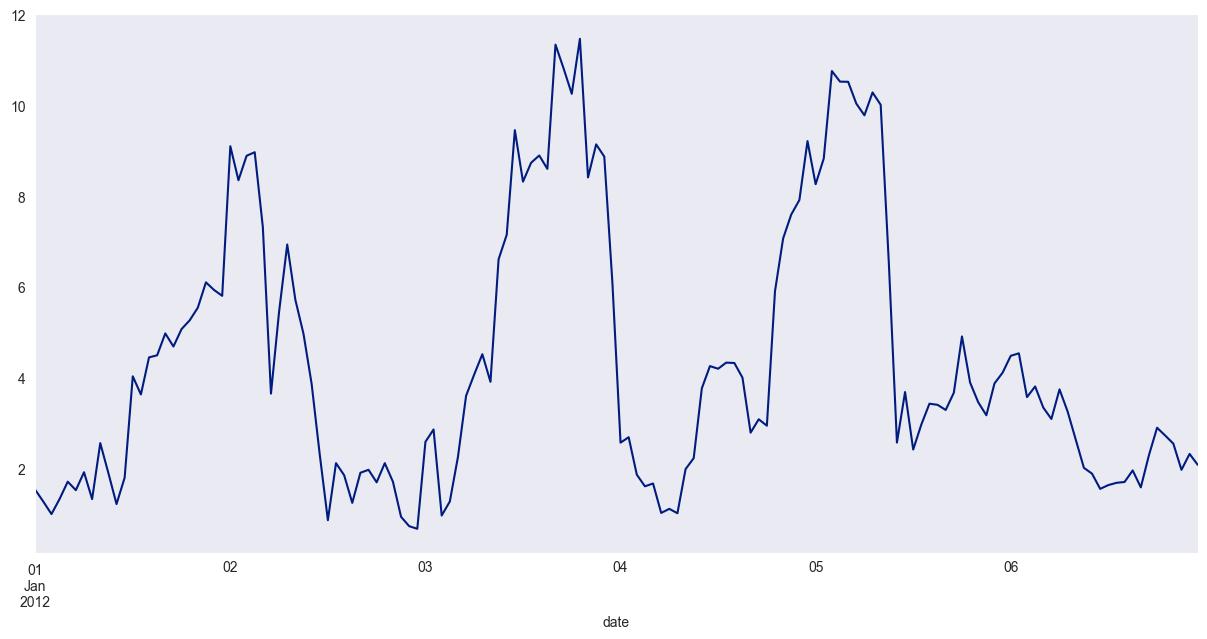

In [11]:
df_hour[df_hour["date"].dt.date.between(date(2012,1,1), date(2012,1,6))].set_index("date").wind_speed.plot(figsize=(15,7))

In [12]:
print(df.loc[df["wind_speed"] == -9999.000000].shape, df.shape)
df.loc[df["wind_speed"] == -9999.000000]

(18, 15) (420551, 15)


,date,internal_pressure,temperature_celsius,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,airtight,wind_speed,maximum_wind_speed,wind_direction_degree,date_diff
343578,2015-07-13 09:10:00,990.49,16.85,12.78,76.90,19.22,14.78,4.44,9.34,14.92,1183.06,-9999.0,-9999.0,359.7,0 days 00:10:00
343579,2015-07-13 09:20:00,990.32,17.06,12.86,76.30,19.48,14.86,4.62,9.39,15.01,1181.97,-9999.0,-9999.0,359.8,0 days 00:10:00
343580,2015-07-13 09:30:00,990.24,17.43,12.75,74.00,19.94,14.76,5.19,9.32,14.90,1180.42,-9999.0,-9999.0,359.8,0 days 00:10:00
343581,2015-07-13 09:40:00,990.27,17.71,12.88,73.30,20.30,14.88,5.42,9.40,15.02,1179.26,-9999.0,-9999.0,359.8,0 days 00:10:00
343582,2015-07-13 09:50:00,990.28,17.76,13.03,73.80,20.36,15.03,5.33,9.49,15.17,1179.00,-9999.0,-9999.0,359.8,0 days 00:10:00
343583,2015-07-13 10:00:00,990.20,17.98,12.74,71.40,20.65,14.74,5.90,9.31,14.89,1178.14,-9999.0,-9999.0,359.8,0 days 00:10:00
343584,2015-07-13 10:10:00,990.17,18.19,12.59,69.78,20.92,14.60,6.32,9.22,14.74,1177.32,-9999.0,-9999.0,359.8,0 days 00:10:00
343585,2015-07-13 10:20:00,990.07,18.31,12.97,71.00,21.08,14.97,6.11,9.46,15.12,1176.55,-9999.0,-9999.0,359.8,0 days 00:10:00
343586,2015-07-13 10:30:00,990.02,18.24,12.88,70.90,20.99,14.88,6.11,9.40,15.03,1176.82,-9999.0,-9999.0,359.8,0 days 00:10:00
343587,2015-07-13 10:40:00,989.96,18.36,12.76,69.84,21.14,14.77,6.38,9.33,14.92,1176.31,-9999.0,-9999.0,359.8,0 days 00:10:00


In [13]:
df.loc[df["wind_speed"] == -9999.000000, "wind_speed"] = None
df.loc[df["maximum_wind_speed"] == -9999.000000, "maximum_wind_speed"] = None

In [14]:
df[cols].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,internal_pressure,temperature_celsius,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,airtight,wind_speed,maximum_wind_speed,wind_direction_degree
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420533.000000,420531.000000,420551.000000
mean,989.212776,9.450147,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,2.130282,3.532242,174.743738
std,8.358481,8.423365,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,1.542304,2.340411,86.681693
min,913.600000,-23.010000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000
1%,966.890000,-10.090000,-12.720000,35.130000,2.830000,2.290000,0.040000,1.430000,2.290000,1132.210000,0.220000,0.520000,5.635000
10%,978.580000,-1.270000,-3.580000,50.990000,5.570000,4.690000,0.360000,2.950000,4.740000,1166.310000,0.570000,1.120000,30.720000
25%,984.200000,3.360000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
90%,999.400000,20.300000,13.500000,95.100000,23.860000,15.500000,10.470000,9.800000,15.670000,1268.810000,4.180000,6.700000,263.000000


# Análise da target

- O primeiro gráfico mostra que a temperatura, como esperado, tem uma alta sazonalidade, sendo menor no começo e fim do ano e maior no meio.
- Pode existir uma sazonalidade mensal, por conta das luas e marés
- Existe também sazonalidade diária, em que as temperaturas mais frias se concentram a noite e as mais quentes ao longo do dia

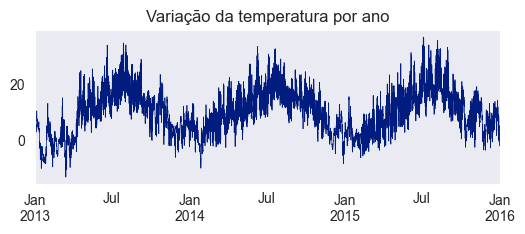

In [ ]:
df_hour[df_hour["date"].dt.date.between(date(2013,1,1), date(2016,1,1))].set_index("date")["temperature_celsius"].plot(figsize=(6,2), linewidth=0.5)
plt.title("Variação da temperatura por ano")
plt.xlabel("")
plt.show()

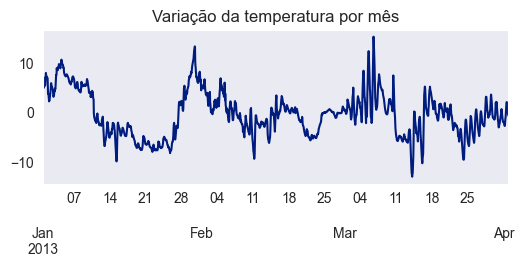

In [29]:
df_hour[df_hour["date"].dt.date.between(date(2013,1,1), date(2013,4,1))].set_index("date")["temperature_celsius"].plot(figsize=(6,2))
plt.title("Variação da temperatura por mês")
plt.xlabel("")
plt.show()

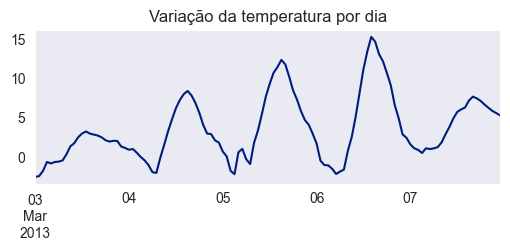

In [32]:
df_hour[df_hour["date"].dt.date.between(date(2013,3,3), date(2013,3,7))].set_index("date")["temperature_celsius"].plot(figsize=(6,2))
plt.title("Variação da temperatura por dia")
plt.xlabel("")
plt.show()

# Correlação entre variáveis


Uma matriz de correlação ajuda a identificar como as variáveis estão relacionadas entre si. Vamos analisar alguns pontos-chave observados:

> Principais Correlações Positivas
1. Temperatura e Pressão de Vapor:

    - A temperatura_celsius possui uma correlação positiva forte com saturation_vapor_pressure (0.951), vapor_pressure (0.867), e specific_humidity (0.867). Isso sugere que o aumento da temperatura do ar está associado a uma maior pressão de vapor e umidade específica.

2. Ponto de Orvalho e Pressão de Vapor:

    - dew_point está fortemente correlacionada com vapor_pressure (0.968) e specific_humidity (0.967), o que faz sentido, pois o ponto de orvalho e a pressão de vapor refletem o conteúdo de umidade do ar.

3. Velocidade e Máxima Velocidade do Vento:

    - wind_speed e maximum_wind_speed têm uma correlação muito alta (0.957), indicando que essas variáveis frequentemente aumentam e diminuem juntas, como esperado.

> Principais Correlações Negativas
1. Temperatura e Airtight:
- temperatura_celsius e airtight têm uma correlação negativa muito forte (-0.963), sugerindo que, quando a airtight aumenta, a temperatura tende a diminuir. O significado específico de airtight não está claro, mas parece capturar uma relação inversa significativa com a temperatura.

2. Umidade Relativa e Deficit de Pressão de Vapor:

- relative_humidity tem uma correlação negativa forte com vapor_pressure_deficit (-0.843). Isso sugere que, quando a umidade relativa aumenta, o déficit de pressão de vapor diminui, o que é intuitivo, pois com mais umidade no ar, a diferença entre a pressão de vapor atual e a pressão de saturação diminui.
3. Pressão Interna e Velocidade do Vento:

- internal_pressure apresenta correlação negativa com wind_speed (-0.209) e maximum_wind_speed (-0.204), indicando que quando a pressão interna aumenta, a velocidade do vento tende a diminuir levemente.

**Considerações para o Modelo**
Essas correlações podem ser úteis para escolher variáveis no modelo preditivo. Por exemplo:

1. Variáveis como vapor_pressure, dew_point, e saturation_vapor_pressure poderiam ser boas candidatas para prever a temperatura_celsius, dado o alto grau de correlação.
2. A forte correlação negativa entre airtight e temperatura_celsius indica que essa variável poderia ser relevante no modelo, talvez para explicar uma variabilidade inversa na temperatura.
3. relative_humidity e vapor_pressure_deficit podem ser incluídas como indicativos de condições de umidade do ar, já que exibem padrões claros.


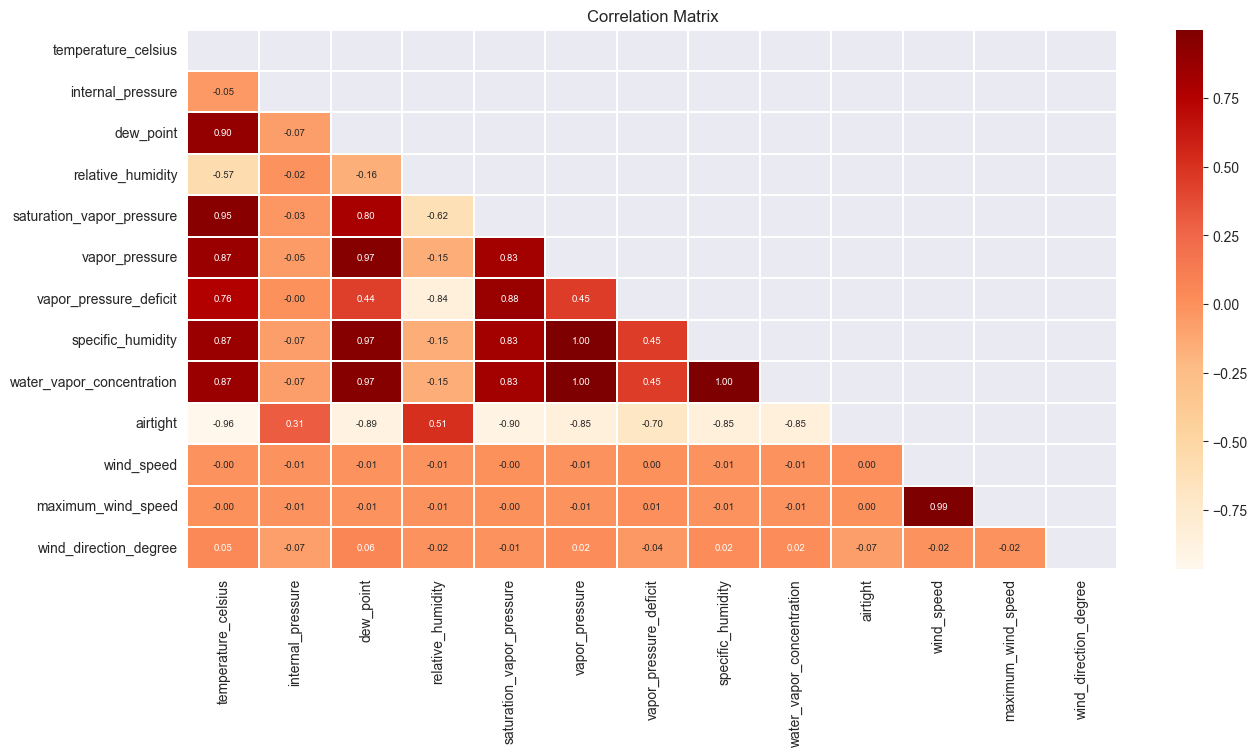

In [17]:
cols = [
    "temperature_celsius",
    "internal_pressure",
    "dew_point",
    "relative_humidity",
    "saturation_vapor_pressure",
    "vapor_pressure",
    "vapor_pressure_deficit",
    "specific_humidity",
    "water_vapor_concentration",
    "airtight",
    "wind_speed",
    "maximum_wind_speed",
    "wind_direction_degree"
    ]
plot_corr_heatmap(df_hour[cols])

> Variáveis altamente correlacionadas (multicolinearidade) podem interferir na qualidade do modelo de várias maneiras, especialmente em modelos lineares, onde a redundância entre variáveis leva a problemas específicos. Veja alguns dos principais impactos:

1. Instabilidade dos Coeficientes e Variância Alta
- No SARIMAX, mais especificamente, que permite a adição de variáveis exógenas, quando duas ou mais variáveis preditoras são fortemente correlacionadas, os coeficientes estimados para essas variáveis tornam-se instáveis. Pequenas alterações nos dados podem causar grandes variações nos coeficientes, comprometendo a interpretação e a confiança nos parâmetros estimados.
- Isso também resulta em variância alta para os coeficientes, o que pode dificultar a identificação de variáveis realmente significativas.
2. Overfitting e Redundância
- A presença de variáveis altamente correlacionadas aumenta o risco de overfitting, pois o modelo “aprende” características redundantes dos dados ao invés de generalizar melhor para novos dados.
A redundância entre variáveis não adiciona nova informação útil para o modelo, aumentando a complexidade sem melhorar o desempenho.
3. Afeta a Convergência em Modelos Complexos
- Em modelos mais complexos, como Redes Neurais, multicolinearidade pode dificultar a convergência do modelo durante o treinamento, pois o modelo pode tentar ajustar várias variáveis com informações muito similares.
Em árvores de decisão ou modelos baseados em árvore, esse efeito é menos prejudicial, pois esses modelos tendem a selecionar uma das variáveis correlacionadas e ignorar as demais.
4. Interpretação Prejudicada
- Se você pretende interpretar os coeficientes de um modelo para explicar o impacto de cada variável no resultado, a multicolinearidade pode tornar a interpretação imprecisa, pois a influência de variáveis altamente correlacionadas fica “diluída” entre elas, dificultando a identificação do papel exato de cada uma.
Como Lidar com Multicolinearidade

**Algumas estratégias para lidar com multicolinearidade incluem:**

1. Remover variáveis redundantes: Selecionar uma entre as variáveis altamente correlacionadas.
2. Combinar variáveis correlacionadas: Criar uma nova feature, como a média ou soma das variáveis correlacionadas.
3. Regularização: Utilizar modelos com regularização, como Ridge ou Lasso, que penalizam coeficientes altos e podem mitigar o impacto da multicolinearidade.

## Teste de estacionariedade 

Modelos de séries temporais como ARIMA exigem que a série seja estacionária para fazer previsões precisas. Isso ocorre porque um modelo para uma série estacionária é mais confiável e pode capturar o comportamento da série de maneira consistente ao longo do tempo.

Esse teste avalia se as propriedades estatísticas da série, como média e variancia, permanecem constantes com o tempo. Por exemplo, significa que o padrão da temperatura média de um ano é similar ao do ano anterior e assim por diante. Dados não estacionários, em geral, possuem tendência de crescimento ou decrescimento.

Em geral, para séries com comportamento mais desconhecido, é muito comum rodar um teste estatístico para verificar se uma série temporal é estacionária ou não, como o teste de Dickey-Fuller ou o Kwiatkowski-Phillips-Schmidt-Shin. 
No caso, como a série tem padrões complexos (como sazonalidade e tendência simultâneas), rodaremos ambos:

In [20]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(series):
    # Teste ADF
    adf_result = adfuller(series, autolag='AIC')
    print(f"ADF Test p-value: {adf_result[1]}")
    if adf_result[1] > 0.05:
        print("ADF: A série não é estacionária (não rejeita H0)")
    else:
        print("ADF: A série é estacionária (rejeita H0)")

    # Teste KPSS
    kpss_result = kpss(series, regression='c', nlags="auto")
    print(f"KPSS Test p-value: {kpss_result[1]}")
    if kpss_result[1] < 0.05:
        print("KPSS: A série não é estacionária (rejeita H0)")
    else:
        print("KPSS: A série é estacionária (não rejeita H0)")

# Exemplo de uso
df_hour = df_hour.ffill()
stationarity_tests(df_hour["temperature_celsius"])


ADF Test p-value: 1.222981209622423e-13
ADF: A série é estacionária (rejeita H0)
KPSS Test p-value: 0.01
KPSS: A série não é estacionária (rejeita H0)


/var/folders/8m/38x5sl6s1h3bjgqcsm90ylq80000gn/T/ipykernel_1504/2155360928.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")


Curiosamente, o teste de Dickey-Fuller e o teste de KPSS retornam hipóteses diferentes, mas como sabemos que há uma sazonalidade clara nos dados, tanto diária, quanto anual, dado os gráficos acima, podemos partir da premissa que a série não é estacionária e será importante realizar a diferenciação, caso seja usado um modelo com base no ARIMA.
Ex:
- Temperatura diurna (sazonalidade diária): A temperatura pode subir durante o dia e cair à noite, mas se a média diária da temperatura for similar ao longo dos meses, isso pode ser considerado estacionário. Ou seja, não há uma tendência crescente ou decrescente na média das temperaturas diárias.